# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
!pip install palmerpenguins

In [2]:
import pandas as pd
from palmerpenguins import load_penguins

In [3]:
penguins = load_penguins()
penguins = penguins.dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [5]:
target = "species"
X = penguins.drop(columns=[target])
y = penguins[target]

In [6]:
#dummy variables
X = pd.get_dummies(X, drop_first=True)
X = X * 1
X

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen,sex_male
0,39.1,18.7,181.0,3750.0,2007,0,1,1
1,39.5,17.4,186.0,3800.0,2007,0,1,0
2,40.3,18.0,195.0,3250.0,2007,0,1,0
4,36.7,19.3,193.0,3450.0,2007,0,1,0
5,39.3,20.6,190.0,3650.0,2007,0,1,1
...,...,...,...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2009,1,0,1
340,43.5,18.1,202.0,3400.0,2009,1,0,0
341,49.6,18.2,193.0,3775.0,2009,1,0,1
342,50.8,19.0,210.0,4100.0,2009,1,0,1


In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_dummies = enc.fit_transform(X)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [13]:
from sklearn.preprocessing import StandardScaler

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

knn = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [14]:
models = {
    "kNN (k=5)": Pipeline([
        ("prep", knn),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),
    "kNN (k=20)": Pipeline([
        ("prep", knn),
        ("clf", KNeighborsClassifier(n_neighbors=20))
    ]),
    "DecisionTree (max_depth=3)": Pipeline([
        ("prep", tree),
        ("clf", DecisionTreeClassifier(max_depth=3, random_state=42))
    ]),
    "DecisionTree (no max depth)": Pipeline([
        ("prep", tree),
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
}

In [15]:
for name, pipe in models.items():
    pipe.fit(X_train, y_train)

In [16]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve
)

In [18]:
import numpy as np

In [22]:
# kNN (k=5)
y_pred_knn5 = models["kNN (k=5)"].predict(X_test)
y_proba_knn5 = models["kNN (k=5)"].predict_proba(X_test)

cm_knn5 = confusion_matrix(y_test, y_pred_knn5)
acc_knn5 = accuracy_score(y_test, y_pred_knn5)

print("kNN (k=5)")
print("Confusion Matrix:\n", cm_knn5)
print("Overall Accuracy:", round(acc_knn5, 4))

labels = np.unique(y_test)
prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred_knn5, labels=labels, average=None, zero_division=0
)
metrics_knn5 = pd.DataFrame({
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "Support": support
}, index=labels)
print("\nPer-Species Metrics (kNN k=5):")
print(metrics_knn5.round(3))

kNN (k=5)
Confusion Matrix:
 [[38  1  0]
 [ 0 17  0]
 [ 0  0 28]]
Overall Accuracy: 0.9881

Per-Species Metrics (kNN k=5):
           Precision  Recall     F1  Support
Adelie         1.000   0.974  0.987       39
Chinstrap      0.944   1.000  0.971       17
Gentoo         1.000   1.000  1.000       28


In [24]:
y_test_bin = pd.get_dummies(y_test).reindex(columns=labels, fill_value=0).values
auc_knn5 = {}
for i, sp in enumerate(labels):
    auc_knn5[sp] = roc_auc_score(y_test_bin[:, i], y_proba_knn5[:, i])
print("AUC per Species (kNN k=5):", auc_knn5)

AUC per Species (kNN k=5): {'Adelie': np.float64(0.9997150997150998), 'Chinstrap': np.float64(0.9995610184372257), 'Gentoo': np.float64(1.0)}


In [23]:
# kNN (k=20)
y_pred_knn20 = models["kNN (k=20)"].predict(X_test)
y_proba_knn20 = models["kNN (k=20)"].predict_proba(X_test)

cm_knn20 = confusion_matrix(y_test, y_pred_knn20)
acc_knn20 = accuracy_score(y_test, y_pred_knn20)

print("kNN (k=20)")
print("Confusion Matrix:\n", cm_knn20)
print("Overall Accuracy:", round(acc_knn20, 4))

prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred_knn20, labels=labels, average=None, zero_division=0
)
metrics_knn20 = pd.DataFrame({
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "Support": support
}, index=labels)
print("\nPer-Species Metrics (kNN k=20):")
print(metrics_knn20.round(3))


kNN (k=20)
Confusion Matrix:
 [[38  1  0]
 [ 0 17  0]
 [ 0  0 28]]
Overall Accuracy: 0.9881

Per-Species Metrics (kNN k=20):
           Precision  Recall     F1  Support
Adelie         1.000   0.974  0.987       39
Chinstrap      0.944   1.000  0.971       17
Gentoo         1.000   1.000  1.000       28


In [25]:
y_test_bin = pd.get_dummies(y_test).reindex(columns=labels, fill_value=0).values
auc_knn20 = {}
for i, sp in enumerate(labels):
    auc_knn20[sp] = roc_auc_score(y_test_bin[:, i], y_proba_knn20[:, i])
print("AUC per Species (kNN k=20):", auc_knn20)

AUC per Species (kNN k=20): {'Adelie': np.float64(1.0), 'Chinstrap': np.float64(1.0), 'Gentoo': np.float64(1.0)}


In [26]:
# Decision Tree (max_depth=3)
y_pred_tree3 = models["DecisionTree (max_depth=3)"].predict(X_test)
y_proba_tree3 = models["DecisionTree (max_depth=3)"].predict_proba(X_test)

cm_tree3 = confusion_matrix(y_test, y_pred_tree3)
acc_tree3 = accuracy_score(y_test, y_pred_tree3)

print("Decision Tree (max_depth=3)")
print("Confusion Matrix:\n", cm_tree3)
print("Overall Accuracy:", round(acc_tree3, 4))

prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred_tree3, labels=labels, average=None, zero_division=0
)
metrics_tree3 = pd.DataFrame({
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "Support": support
}, index=labels)
print("Per-Species Metrics (Decision Tree depth=3):")
print(metrics_tree3.round(3))

Decision Tree (max_depth=3)
Confusion Matrix:
 [[38  1  0]
 [ 2 15  0]
 [ 0  0 28]]
Overall Accuracy: 0.9643
Per-Species Metrics (Decision Tree depth=3):
           Precision  Recall     F1  Support
Adelie         0.950   0.974  0.962       39
Chinstrap      0.938   0.882  0.909       17
Gentoo         1.000   1.000  1.000       28


In [27]:
y_test_bin = pd.get_dummies(y_test).reindex(columns=labels, fill_value=0).values
auc_tree3 = {}
for i, sp in enumerate(labels):
    auc_tree3[sp] = roc_auc_score(y_test_bin[:, i], y_proba_tree3[:, i])
print("AUC per Species (Decision Tree depth=3):", auc_tree3)

AUC per Species (Decision Tree depth=3): {'Adelie': np.float64(0.9880341880341881), 'Chinstrap': np.float64(0.9833187006145742), 'Gentoo': np.float64(1.0)}


In [28]:
# Decision Tree (no max depth)
y_pred_tree_full = models["DecisionTree (no max depth)"].predict(X_test)
y_proba_tree_full = models["DecisionTree (no max depth)"].predict_proba(X_test)

cm_tree_full = confusion_matrix(y_test, y_pred_tree_full)
acc_tree_full = accuracy_score(y_test, y_pred_tree_full)

print("Decision Tree (no max depth) ===")
print("Confusion Matrix:\n", cm_tree_full)
print("Overall Accuracy:", round(acc_tree_full, 4))

prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred_tree_full, labels=labels, average=None, zero_division=0
)
metrics_tree_full = pd.DataFrame({
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "Support": support
}, index=labels)
print("Per-Species Metrics (Decision Tree full):")
print(metrics_tree_full.round(3))


Decision Tree (no max depth) ===
Confusion Matrix:
 [[37  2  0]
 [ 0 17  0]
 [ 0  0 28]]
Overall Accuracy: 0.9762
Per-Species Metrics (Decision Tree full):
           Precision  Recall     F1  Support
Adelie         1.000   0.949  0.974       39
Chinstrap      0.895   1.000  0.944       17
Gentoo         1.000   1.000  1.000       28


In [29]:
y_test_bin = pd.get_dummies(y_test).reindex(columns=labels, fill_value=0).values
auc_tree_full = {}
for i, sp in enumerate(labels):
    auc_tree_full[sp] = roc_auc_score(y_test_bin[:, i], y_proba_tree_full[:, i])
print("AUC per Species (Decision Tree full):", auc_tree_full)

AUC per Species (Decision Tree full): {'Adelie': np.float64(0.9743589743589743), 'Chinstrap': np.float64(0.9850746268656717), 'Gentoo': np.float64(1.0)}


In [36]:
model = models["DecisionTree (max_depth=3)"]
species = "Gentoo"

y_proba = model.predict_proba(X_test)
classes = list(model.named_steps["clf"].classes_)
species_idx = classes.index(species)
y_score = y_proba[:, species_idx]
y_true_bin = (y_test == species).astype(int)

fpr, tpr, thresholds = roc_curve(y_true_bin, y_score)
auc_value = roc_auc_score(y_true_bin, y_score)

roc_df = pd.DataFrame({
    "False Positive Rate": fpr,
    "True Positive Rate": tpr
})

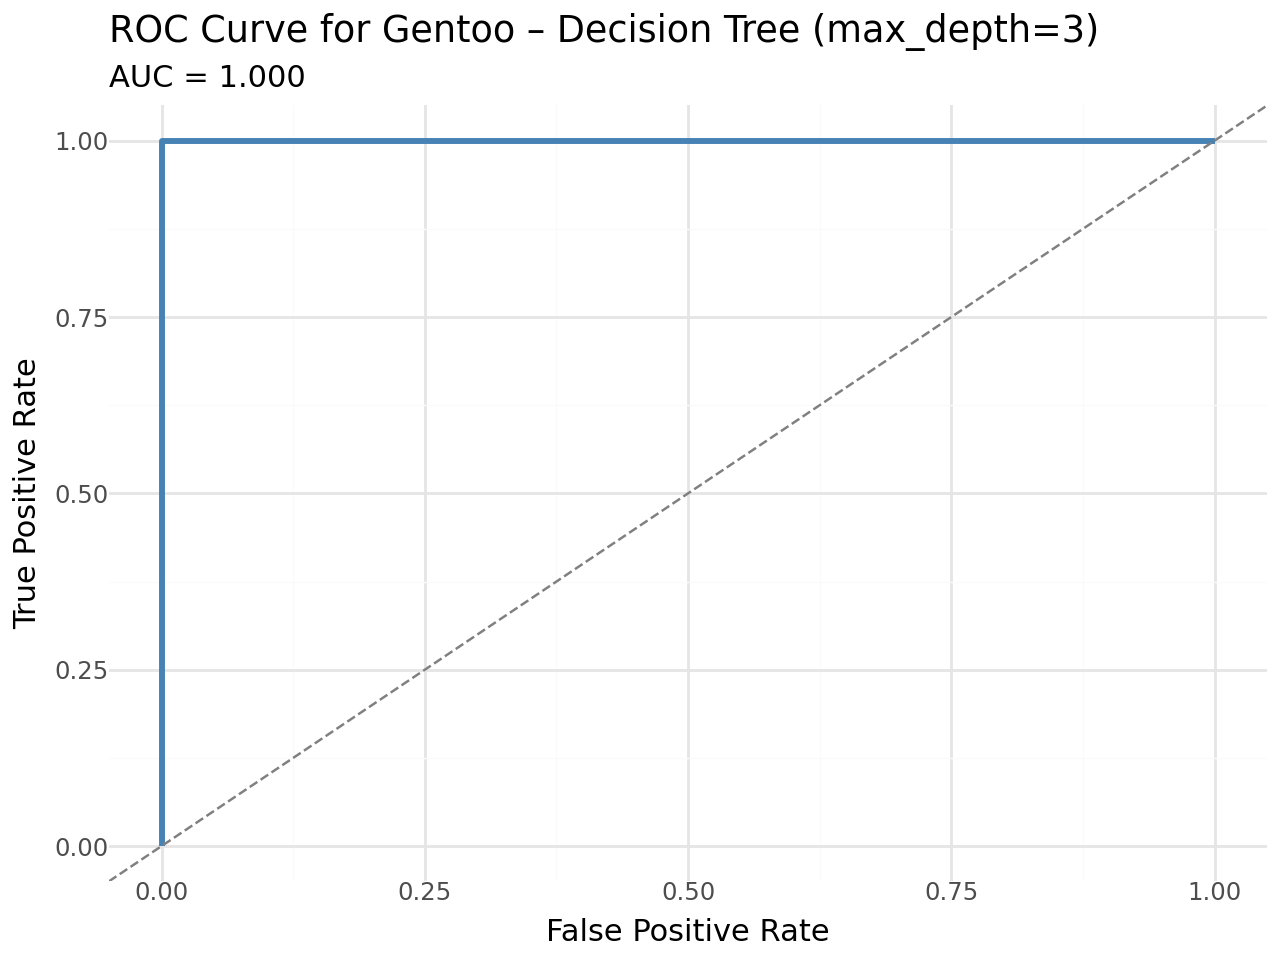

In [35]:
from plotnine import *

# plot gentoo
(
    ggplot(roc_df, aes(x="False Positive Rate", y="True Positive Rate"))
    + geom_line(color="steelblue", size=1.2)
    + geom_abline(linetype="dashed", color="gray")
    + theme_minimal()
    + ggtitle(f"ROC Curve for {species} – Decision Tree (max_depth=3)")
    + labs(
        subtitle=f"AUC = {auc_value:.3f}",
        x="False Positive Rate",
        y="True Positive Rate"
    )
)
